# GNN Evaluation

## 0. setup

In [ ]:
!pip install torch==2.0.0

In [ ]:
import torch
import os

os.environ['TORCH'] = torch.__version__

!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install torch_geometric
!pip install tensorboard

Looking in links: https://data.pyg.org/whl/nightly/torch-2.0.0+cu117.html


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.nn import Linear, Embedding, LeakyReLU, Dropout
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GATv2Conv, to_hetero
from torch_geometric.transforms import ToUndirected
from torch_geometric.data import HeteroData
import matplotlib.pyplot as plt
from joblib import load
import pandas as pd
import numpy as np
import torch
import os

## 1. Model

In [ ]:
from torch_geometric.nn import GATv2Conv, to_hetero
from torch_geometric.transforms import ToUndirected
from torch.nn import Linear, Embedding, LeakyReLU, Dropout
from torch_geometric.data import HeteroData
import pandas as pd
import numpy as np
import torch
import os


class ProductEncoder(torch.nn.Module):
    """
    The ProductEncoder is designed to process the feature vectors of product nodes
    in a heterogeneous graph. It employs a simple multi-layer perceptron (MLP) with
    LeakyReLU activation and three linear layers to reduce the dimensionality of the
    product feature vectors from their original dimension (in_channels) to a smaller
    output dimension (out_channels).

    This transformation is necessary because product nodes begin with 769-dimensional
    feature vectors, whereas customer nodes have only 15 dimensions. Without this
    dimensionality reduction, it would be difficult to balance the feature size for
    both node types while ensuring the output dimension is not too large for customer
    nodes or too small for product nodes.

    Args:
        in_channels (int): Dimensionality of the original product feature vectors.
        hidden_channels (int): Dimensionality of the hidden layers in the encoder.
        out_channels (int): Dimensionality of the final output feature vectors.

    Example usage:
        encoder = ProductEncoder(in_channels=769, hidden_channels=512, out_channels=128)
        product_embeddings = encoder(product_features)
    """

    def __init__(self, in_channels, hidden_channels, out_channels):
        """
        Initializes the ProductEncoder by defining three linear layers that gradually
        reduce the dimensionality of product feature vectors, along with LeakyReLU
        activations applied after the first two layers.

        Args:
            in_channels (int): Initial dimensionality of product feature vectors (e.g., 769).
            hidden_channels (int): Dimensionality of the intermediate layers.
            out_channels (int): Final dimensionality of the product embeddings after encoding.
        """
        super().__init__()
        self.lin1 = Linear(in_channels, hidden_channels)
        self.drop1 = Dropout(0.2)
        self.lin2 = Linear(hidden_channels, hidden_channels//2)
        self.drop2 = Dropout(0.2)
        self.lin3 = Linear(hidden_channels//2, out_channels)

    def forward(self, x):
        """
        Forward pass through the ProductEncoder. The input feature vectors are passed through
        three linear layers with LeakyReLU activations after the first two, resulting in
        encoded product features of a smaller, more manageable dimensionality.

        Args:
            x (torch.Tensor): Input tensor of product feature vectors. Shape [num_products, in_channels].

        Returns:
            torch.Tensor: Encoded product feature vectors with dimensionality [num_products, out_channels].
        """
        x = self.lin1(x)
        x = LeakyReLU()(x)
        x = self.drop1(x)
        x = self.lin2(x)
        x = LeakyReLU()(x)
        x = self.drop2(x)
        x = self.lin3(x)
        return x


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, edge_dim):
        """
        The GNNEncoder generates the embeddings for all nodes in the graph.
        The hidden_channels is the dimensionality of the embeddings inside
        the GNN. The out_channels is the dimensionality of the final node
        embeddings.
        """
        super().__init__()
        # The first layer transforms the input node features from their original dimension to hidden_channels dimension.
        self.conv1 = GATv2Conv((-1, -1), hidden_channels, edge_dim=edge_dim, add_self_loops=False, dropout=0.2, heads=5)  # Aggregates information from the node's 1-hop neighbors
        self.conv2 = GATv2Conv(hidden_channels * 5, hidden_channels, edge_dim=edge_dim, add_self_loops=False, dropout=0.2, heads=5)  # Aggregates information from the node's 2-hop neighbors
        self.conv3 = GATv2Conv(hidden_channels * 5, out_channels, edge_dim=edge_dim, add_self_loops=False, dropout=0.2, heads=5)  # Aggregates information from the node's 3-hop neighbors

    def forward(self, x, edge_index, edge_attr):
        """
        Performs message passing through the graph to update node embeddings.

        Args:
            x (torch.Tensor): The feature matrix of all nodes in the graph.
                              Shape [num_nodes, num_node_features].
            edge_index (torch.Tensor): The edge list representing connections in the graph.
                                       Shape [2, num_edges] (COO format).
            edge_attr (torch.Tensor): The edge feature matrix for all edges in the graph.
                                      Shape [num_edges, edge_dim].

        Returns:
            torch.Tensor: The updated node embeddings for all nodes in the graph.
                          Shape [num_nodes, out_channels].
        """
        # Apply 5 layers of message passing, updating node embeddings based on neighbors at increasing distances.
        x = self.conv1(x, edge_index, edge_attr).relu()  # Update embeddings with 1-hop neighbors
        x = self.conv2(x, edge_index, edge_attr).relu()  # Update embeddings with 2-hop neighbors
        x = self.conv3(x, edge_index, edge_attr)  # Update embeddings with 3-hop neighbors
        return x


class GNNDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        """
        A decoder that takes two node embeddings and predicts the probability of an edge between them.

        Args:
            hidden_channels (int): The size of the hidden dimension and also the size of the input node embeddings.
        """
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels * 5, hidden_channels)  # Adjusted for multi-head attention
        self.drop1 = Dropout(0.2)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.drop2 = Dropout(0.2)
        self.lin3 = torch.nn.Linear(hidden_channels // 2, 1)  # Outputs the probability of an edge

    def forward(self, embeddings_dict, edge_index):
        """
        Forward pass that computes edge probabilities for all specified node pairs.

        Args:
            z_dict (dict): Node embeddings for all node types (e.g., 'customer' and 'product').
            edge_index (torch.Tensor): Edge indices for which to compute probabilities.

        Returns:
            torch.Tensor: Predicted edge probabilities for the specified edges.
        """
        # Concatenate customer and product embeddings for each edge
        row, col = edge_index
        z = torch.cat([embeddings_dict['customer'][row], embeddings_dict['product'][col]], dim=-1)

        # Pass concatenated embeddings through the linear layers
        z = self.lin1(z).relu()
        z = self.drop1(z)
        z = self.lin2(z).relu()
        z = self.drop2(z)
        z = self.lin3(z)

        # Apply sigmoid to get probabilities
        return torch.sigmoid(z.view(-1))  # Output edge probabilities for all pairs

class GNN(torch.nn.Module):
    def __init__(
        self,
        product_encoder_in_channels: int,
        product_encoder_hidden_channels: int,
        product_encoder_out_channels: int,
        gnn_encoder_hidden_channels: int,
        gnn_encoder_out_channels: int,
        graph_edge_dim: int,
        graph: HeteroData,
    ):
        super().__init__()

        # Initialize product encoder
        self.product_encoder = ProductEncoder(
            in_channels=product_encoder_in_channels,
            hidden_channels=product_encoder_hidden_channels,
            out_channels=product_encoder_out_channels,
        )

        # Initialize GNN encoder
        gnn_encoder = GNNEncoder(
            hidden_channels=gnn_encoder_hidden_channels,
            out_channels=gnn_encoder_out_channels,
            edge_dim=graph_edge_dim,
        )

        # Convert GNN encoder to a heterogeneous GNN
        self.gnn_encoder = to_hetero(gnn_encoder, graph.metadata(), aggr="sum")

        # Initialize GNN decoder
        self.gnn_decoder = GNNDecoder(gnn_encoder_out_channels)

    def forward(
        self,
        products: torch.Tensor,
        x_dict: dict[str, torch.Tensor],
        edge_index_dict: dict[tuple, torch.Tensor],
        edge_attr_dict: dict[tuple, torch.Tensor],
        edge_label_index: torch.Tensor,
    ) -> torch.Tensor:
        # Encode product features and update node dictionary
        x_dict["product"] = self.product_encoder(products)

        # Encode node features using the heterogeneous GNN encoder
        node_embeddings = self.gnn_encoder(x_dict, edge_index_dict, edge_attr_dict)

        # Decode edge probabilities
        return self.gnn_decoder(node_embeddings, edge_label_index)


## 2. load data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive_path = "drive/MyDrive/SJ_PCD_24-2/"

# load graph
graph_path = drive_path + "data/transformed/graph.pth"
data = torch.load(graph_path, weights_only=False)

# load products scaler
product_scaler_path = drive_path + "data/transformed_v2/product_scaler.pkl"
product_scaler = load(product_scaler_path)

# load customer scaler
customer_scaler_path = drive_path + "data/transformed_v2/customer_scaler.pkl"
customer_scaler = load(customer_scaler_path)

# load edge scaler
edge_scaler_path = drive_path + "data/transformed_v2/edge_scaler.pkl"
edge_scaler = load(edge_scaler_path)

# load rev edge scaler
rev_edge_scaler_path = drive_path + "data/transformed_v2/rev_edge_scaler.pkl"
rev_edge_scaler = load(rev_edge_scaler_path)

# load test data
test_data_path = drive_path + "data/transformed_v2/test_data.pth"
test_data = torch.load(test_data_path) # already normalized

# load model
model = GNN(
    product_encoder_in_channels=770,
    product_encoder_hidden_channels=512,
    product_encoder_out_channels=128,
    gnn_encoder_hidden_channels=128,
    gnn_encoder_out_channels=64,
    graph_edge_dim=13,
    graph=data
)

model = model.to(device)
model_path = drive_path + "v3_gnn_checkpoints/model_checkpoint_batch_28640.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

## 3. evaluate function

In [ ]:
def create_test_dataloader(batch_size: int):
    edge_label_index = (("customer", "bought", "product"), test_data[("customer", "bought", "product")].edge_label_index)
    edge_label = test_data[("customer", "bought", "product")].edge_label
    return LinkNeighborLoader(
        data=test_data,
        num_neighbors=[5, 5, 5],
        neg_sampling_ratio=0,
        edge_label_index=edge_label_index,
        edge_label=edge_label,
        batch_size=batch_size,
        shuffle=True,
    )

def prepare_batch_for_fitting(batch):
    products = batch["product"].x
    x_dict = batch.x_dict

    edge_index_dict = {
        ("customer", "bought", "product"): batch[("customer", "bought", "product")].edge_index,
        ("product", "rev_bought", "customer"): batch[("product", "rev_bought", "customer")].edge_index
    }

    edge_attr_dict = {
        ("customer", "bought", "product"): batch[("customer", "bought", "product")].edge_attr,
        ("product", "rev_bought", "customer"): batch[("product", "rev_bought", "customer")].edge_attr
    }

    edge_label_index = batch[("customer", "bought", "product")].edge_label_index
    labels = batch[("customer", "bought", "product")].edge_label

    return products, x_dict, edge_index_dict, edge_attr_dict, edge_label_index, labels

def evaluate(model, test_dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):

            batch.to(device)
            products, x_dict, edge_index_dict, edge_attr_dict, edge_label_index, labels = prepare_batch_for_fitting(batch)
            outputs = model(products, x_dict, edge_index_dict, edge_attr_dict, edge_label_index)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions = (outputs > 0.5).float().cpu()  # Convert probabilities to binary predictions and move to CPU
            labels = labels.cpu()  # Move labels to CPU

            all_predictions.append(predictions)
            all_labels.append(labels)

            # Compute accuracy for this batch
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    # Concatenate all the predictions and labels across batches
    all_predictions = torch.cat(all_predictions).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_dataloader)
    accuracy = correct_predictions / total_samples

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_predictions

def plot_evaluation_metrics(all_labels, all_predictions):
    """
    Plot the confusion matrix and ROC curve with AUC score for the model's predictions on the test set.

    Args:
        all_labels (np.array): True labels for the test set.
        all_predictions (np.array): Model's predicted probabilities for the test set.
    """

    # Calculate confusion matrix and display it
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()
    print()

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()


## 4. evaluate

In [ ]:
test_batch_size = 8192
test_dataloader = create_test_dataloader(batch_size=test_batch_size)

avg_loss, acc, pre, rec, f1, all_labels, all_predictions = evaluate(
    model=model,
    test_dataloader=test_dataloader,
    criterion=torch.nn.BCELoss(),
    device=device
)

Test Loss: 0.3801
Test Accuracy: 0.8353
Test Precision: 0.7112
Test Recall: 0.5745
Test F1-Score: 0.6355


# explanation

- 83% of predictions are correct
- 71% of the time I say a customer will buy a product, I'm correct
- Out of 100 purchases, I predict 57 of them

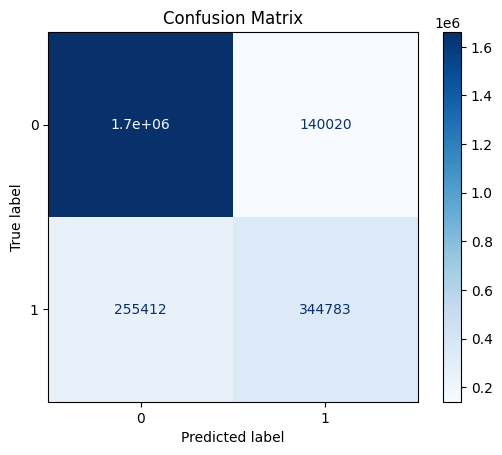

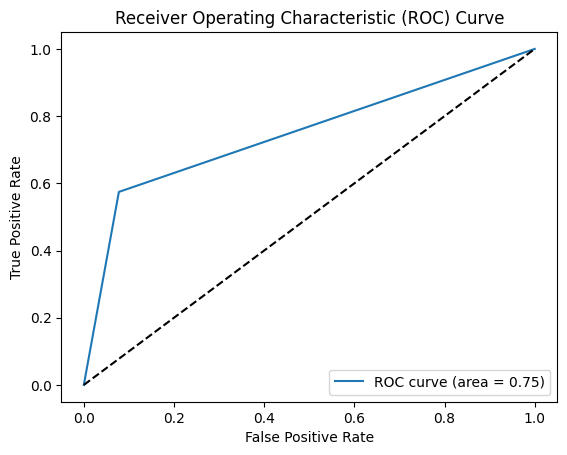

In [ ]:
plot_evaluation_metrics(all_labels, all_predictions)